In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

In [17]:
import folium
from folium.plugins import HeatMap
import webbrowser

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
ee.Initialize()

df= pd.read_csv('extracted_tornado.csv')

gdf= gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.BEGIN_LON, df.BEGIN_LAT))

In [3]:
gdf= gpd.read_file('tornado_loc.shp')

In [4]:
gdf['year']= gdf.BEGIN_YEAR//100

In [5]:
gdf['LandCover_Begin']= None
gdf['LandUse_Begin']= None

In [6]:
gdf= gdf[~pd.isna(gdf.BEGIN_LON)]

In [7]:
ee_values= {'landcover':[], 'landuse':[],'coords':[]}
for year in gdf.year.unique():
    if year<=1985:
        tar_year= 1985
    else: tar_year=year
    
    landcover= ee.Image('USFS/GTAC/LCMS/v2020-5/LCMS_CONUS_v2020-5_%d'%tar_year).select(1)
    landuse= ee.Image('USFS/GTAC/LCMS/v2020-5/LCMS_CONUS_v2020-5_%d'%tar_year).select(2)        
    _gdf= gdf[gdf.year==year]
    points= ee.Geometry.MultiPoint([[_gdf.iloc[j].BEGIN_LON, _gdf.iloc[j].BEGIN_LAT] for j in range(len(_gdf))])
    return_js= landcover.sampleRegions(collection=points, scale=30, geometries=True)
    return_dict= return_js.getInfo()
    lcs= [feature['properties']['Land_Cover'] for feature in return_dict['features']]
    return_js= landuse.sampleRegions(collection=points, scale=30, geometries=True)
    return_dict= return_js.getInfo()    
    lus= [feature['properties']['Land_Use'] for feature in return_dict['features']]
    coords= [feature['geometry']['coordinates'] for feature in return_dict['features']]
    ee_values['landcover'].append(lcs)
    ee_values['landuse'].append(lus)
    ee_values['coords'].append(coords)
    
coords= sum(ee_values['coords'],[])
lus= sum(ee_values['landuse'],[])
lcs=sum(ee_values['landcover'],[])

# for i, [lon, lat] in enumerate(coords):
#     inds= gdf[(abs(gdf.BEGIN_LON-lon)<1e-4) & (abs(gdf.BEGIN_LAT-lat)<1e-4)].index
#     gdf.loc[inds,'LandCover']= lcs[i]    
#     gdf.loc[inds,'LandUse']= lus[i]

In [8]:
for i, [lon, lat] in enumerate(coords):
    inds= gdf[(abs(gdf.BEGIN_LON-lon)<1e-3) & (abs(gdf.BEGIN_LAT-lat)<1e-3)].index
    gdf.loc[inds,'LandCover_Begin']= lcs[i]    
    gdf.loc[inds,'LandUse_Begin']= lus[i]

In [9]:
gdf['LandCover_End']= None
gdf['LandUse_End']= None

In [10]:
ee_values= {'landcover':[], 'landuse':[],'coords':[]}
for year in gdf.year.unique():
    if year<=1985:
        tar_year= 1985
    else: tar_year=year
    
    landcover= ee.Image('USFS/GTAC/LCMS/v2020-5/LCMS_CONUS_v2020-5_%d'%tar_year).select(1)
    landuse= ee.Image('USFS/GTAC/LCMS/v2020-5/LCMS_CONUS_v2020-5_%d'%tar_year).select(2)        
    _gdf= gdf[gdf.year==year]
    points= ee.Geometry.MultiPoint([[_gdf.iloc[j].END_LON, _gdf.iloc[j].END_LAT] for j in range(len(_gdf)) if not pd.isna(_gdf.iloc[j].END_LON)])
    return_js= landcover.sampleRegions(collection=points, scale=30, geometries=True)
    return_dict= return_js.getInfo()
    lcs= [feature['properties']['Land_Cover'] for feature in return_dict['features']]
    return_js= landuse.sampleRegions(collection=points, scale=30, geometries=True)
    return_dict= return_js.getInfo()    
    lus= [feature['properties']['Land_Use'] for feature in return_dict['features']]
    coords= [feature['geometry']['coordinates'] for feature in return_dict['features']]
    ee_values['landcover'].append(lcs)
    ee_values['landuse'].append(lus)
    ee_values['coords'].append(coords)
    
coords= sum(ee_values['coords'],[])
lus= sum(ee_values['landuse'],[])
lcs=sum(ee_values['landcover'],[])

In [11]:
for i, [lon, lat] in enumerate(coords):
    inds= gdf[(abs(gdf.END_LON-lon)<1e-3) & (abs(gdf.END_LAT-lat)<1e-3)].index
    gdf.loc[inds,'LandCover_End']= lcs[i]    
    gdf.loc[inds,'LandUse_End']= lus[i]

In [12]:
gdf

,Unnamed_ 0,BEGIN_YEAR,BEGIN_DAY,BEGIN_TIME,END_YEARMO,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,...,DATA_SOURC,year_1,LandCover,LandUse,geometry,year,LandCover_Begin,LandUse_Begin,LandCover_End,LandUse_End
0,0,195004,28,1445,195004,28,1445,NaN,10096222,OKLAHOMA,...,PUB,1950,10,1,POINT (-99.20000 35.12000),1950,15,1,15,1
1,1,195004,29,1530,195004,29,1530,NaN,10120412,TEXAS,...,PUB,1950,12,7,POINT (-98.60000 31.90000),1950,15,7,15,7
2,2,195007,5,1800,195007,5,1800,NaN,10104927,PENNSYLVANIA,...,PUB,1950,10,3,POINT (-75.70000 40.58000),1950,10,3,10,4
3,3,195007,5,1830,195007,5,1830,NaN,10104928,PENNSYLVANIA,...,PUB,1950,10,1,POINT (-76.75000 40.60000),1950,10,1,None,None
4,4,195007,24,1440,195007,24,1440,NaN,10104929,PENNSYLVANIA,...,PUB,1950,10,2,POINT (-79.68000 41.63000),1950,1,2,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69199,39717,202006,4,159,202006,4,200,148826.0,896594,MISSOURI,...,CSV,2020,1,2,POINT (-94.33160 38.47190),2020,1,2,10,3
69200,39828,202006,28,1954,202006,28,1956,149511.0,901206,MINNESOTA,...,CSV,2020,10,1,POINT (-91.72380 44.03180),2020,10,1,14,1
69201,39961,202006,10,1718,202006,10,1724,147398.0,886388,OHIO,...,CSV,2020,10,1,POINT (-83.07910 39.37860),2020,10,1,10,3
69202,39964,202006,7,1741,202006,7,1742,147784.0,889521,FLORIDA,...,CSV,2020,14,5,POINT (-81.70400 28.79140),2020,1,5,1,3


In [12]:
landcover_mapper= {
1: "Trees",
2: "Tall Shrubs & Trees Mix (SEAK Only)",
3: "Shrubs & Trees Mix",
4: "Grass/Forb/Herb & Trees Mix",
5: "Barren & Trees Mix",
6: "Tall Shrubs (SEAK Only)",
7: "Shrubs",
8: "Grass/Forb/Herb & Shrubs Mix",
9: "Barren & Shrubs Mix",
10:"Grass/Forb/Herb",
11:"Barren & Grass/Forb/Herb Mix",
12:"Barren or Impervious",
13:"Snow or Ice",
14:"Water",
15:"Non-Processing Area Mask"
}

landuse_mapper = {
1: "Agriculture",
2: "Developed",
3: "Forest",
4: "Non-Forest Wetland",
5: "Other",
6: "Rangeland or Pasture",
7: "Non-Processing Area Mask",
}

In [13]:
gdf.to_file('tornado_loc.shp')

/var/folders/c7/5k73klb12cg2ysz6c890vdm00000gn/T/ipykernel_41069/2274426073.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('tornado_loc.shp')


In [13]:
gdf.LandCover.map(landcover_mapper)

0             Grass/Forb/Herb
1        Barren or Impervious
2             Grass/Forb/Herb
3             Grass/Forb/Herb
4             Grass/Forb/Herb
                 ...         
70264                   Trees
70265         Grass/Forb/Herb
70266         Grass/Forb/Herb
70267                   Water
70268         Grass/Forb/Herb
Name: LandCover, Length: 69204, dtype: object

In [39]:
gdf.LandUse.map(landuse_mapper).value_counts()

Agriculture                 21920
Forest                      19245
Rangeland or Pasture        12042
Developed                    9072
Non-Processing Area Mask     3978
Other                        2099
Non-Forest Wetland            714
Name: LandUse, dtype: int64

<AxesSubplot:ylabel='Frequency'>

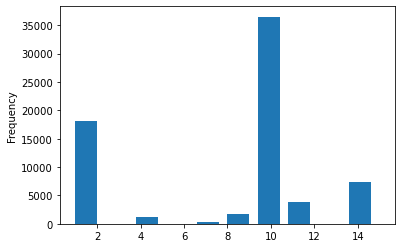

In [30]:
gdf.LandCover.plot(kind='hist', width=1)

<AxesSubplot:ylabel='Frequency'>

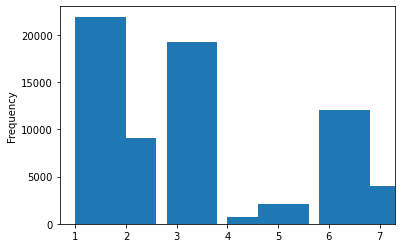

In [31]:
gdf.LandUse.plot(kind='hist', width=1)

In [61]:
lat = gdf.BEGIN_LAT.values
lon = gdf.BEGIN_LON.values
# js = np.array(posi[“js”][0:num],dtype=float)
vals= gdf.LandUse.values.astype(float)
data1 = [[lat[i],lon[i],vals[i]] for i in range(len(lat)) if not np.isnan(vals[i])]

In [62]:
map_osm = folium.Map(location=[29.97,-102.97],zoom_start=5,tiles='StamenTerrain',control_scale=True)
HeatMap(data1).add_to(map_osm)
out = r"tornado_loc.html"
map_osm.save(out)

In [63]:
webbrowser.open(out)

True